<ipython-input-1-d4073f000c69>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(0, inplace=True)


   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.277445             0   
1       1              0        0           0  0.066327             1   
2       1              0        0           0 -1.236724             1   
3       1              0        0           0  0.514251             0   
4       0              0        0           0 -1.236724             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1       -1.160323     -0.992611      0  ...   
1                 0       -0.259629     -0.172165      0  ...   
2                 1       -0.362660     -0.958066      1  ...   
3                 0       -0.746535     -0.193672      0  ...   
4                 1        0.197365     -0.938874      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            False        

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: Logistic Regression
              precision    recall  f1-score   support

           0     0.8574    0.8425    0.8499      1035
           1     0.5842    0.6123    0.5979       374

    accuracy                         0.7814      1409
   macro avg     0.7208    0.7274    0.7239      1409
weighted avg     0.7849    0.7814    0.7830      1409

ROC AUC Score: 0.8352

Model: Random Forest
              precision    recall  f1-score   support

           0     0.8475    0.8589    0.8532      1035
           1     0.5944    0.5722    0.5831       374

    accuracy                         0.7828      1409
   macro avg     0.7210    0.7156    0.7181      1409
weighted avg     0.7803    0.7828    0.7815      1409

ROC AUC Score: 0.8297

Model: XGBoost
              precision    recall  f1-score   support

           0     0.8696    0.7990    0.8328      1035
           1     0.5459    0.6684    0.6010       374

    accuracy                         0.7644      1409
   macro avg     0

<ipython-input-1-d4073f000c69>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette="Blues_r")


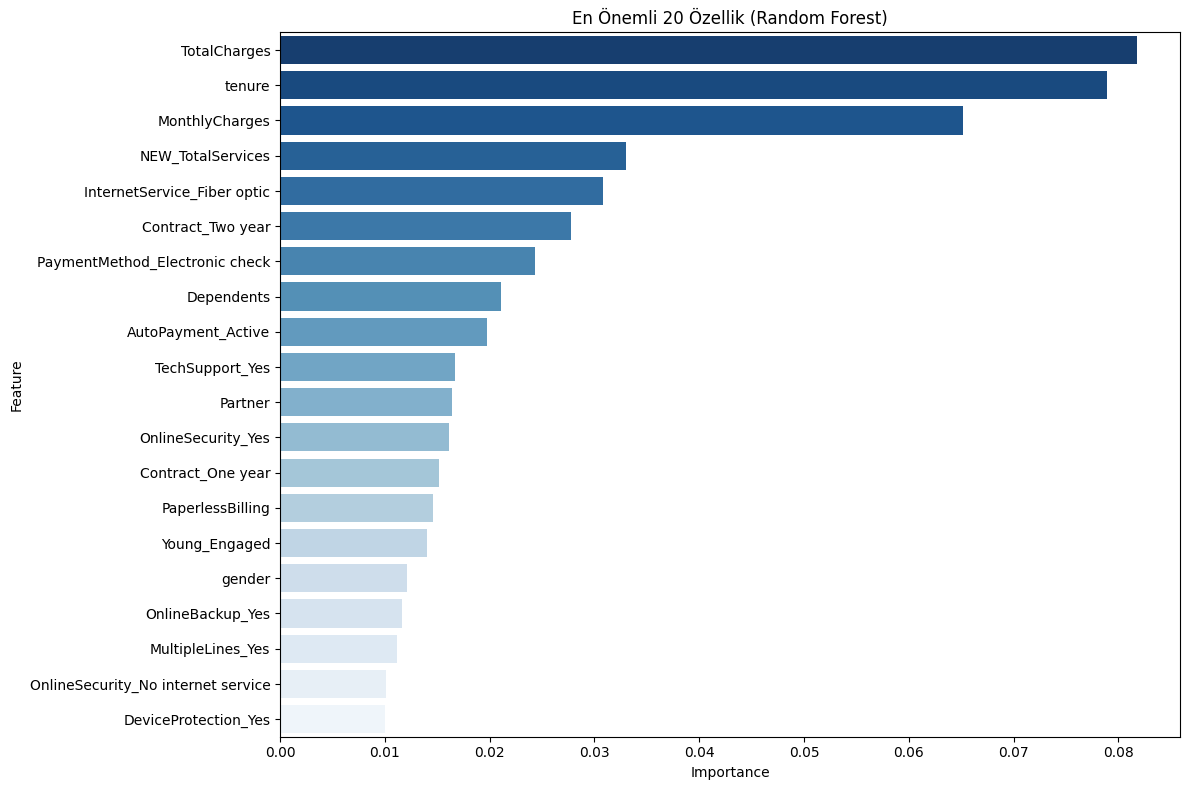

Fitting 3 folds for each of 12 candidates, totalling 36 fits
En İyi Parametreler: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.8511    0.8618    0.8565      1035
           1     0.6039    0.5829    0.5932       374

    accuracy                         0.7878      1409
   macro avg     0.7275    0.7224    0.7248      1409
weighted avg     0.7855    0.7878    0.7866      1409



In [ ]:
# 📚 Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE


# 📂 Veri Seti Yükleme
path = "/content/drive/MyDrive/Telco-Customer-Churn.csv adlı dosyanın kopyası"
df = pd.read_csv(path)

# 🛠 Veri Ön İşleme
## 🔹 TotalCharges sütununu sayısal değere dönüştür
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

## 🔹 Churn sütununu binary (1-0) formata çevir
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

## 🔹 Eksik değerleri doldur
df["TotalCharges"].fillna(0, inplace=True)

# 🎯 Özellik Mühendisliği
## 🔹 NEW_TotalServices: Kullanıcının sahip olduğu toplam hizmet sayısı
df["NEW_TotalServices"] = (df[[
    "PhoneService", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies"
]] == "Yes").sum(axis=1)

## 🔹 Streaming_Flag: Streaming hizmeti kullananları bayrakla
df["Streaming_Flag"] = ((df["StreamingTV"] == "Yes") | (df["StreamingMovies"] == "Yes")).astype(int)

## 🔹 Young_Engaged: Genç ve sözleşmeli müşteri
df["Young_Engaged"] = ((df["SeniorCitizen"] == 0) & (df["Contract"] == "One year")).astype(int)

## 🔹 AutoPayment_Active: Otomatik ödeme kullananlar
df["AutoPayment_Active"] = df["PaymentMethod"].str.contains("automatic", case=False).astype(int)

# 🎨 Kategorik Değişken İşlemleri
## 🔹 Kategorik değişkenleri belirle
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

## 🔹 Binary kolonları Label Encoding uygula
binary_cols = [col for col in cat_cols if df[col].nunique() == 2]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

## 🔹 Çok sınıflı kategorik kolonlara One-Hot Encoding uygula
df = pd.get_dummies(df, columns=[col for col in cat_cols if col not in binary_cols], drop_first=True)

# 🧹 Sayısal Değişkenleri Standardize Etme
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 🔍 Final Veri Kontrolü
print(df.head())
print(f"\n✅ Hazırlanan veri setinin boyutu: {df.shape}")

# 📊 Özellikler (X) ve Hedef (y) Ayrımı
X = df.drop("Churn", axis=1)
y = df["Churn"]

# ✂️ Eğitim ve Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 🔄 Veri Dengesizliği ile Mücadele: SMOTE Uygulaması
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 🎨 Görsel Stil: DataFrame'i şık bir şekilde göster
styled_df = df.style.background_gradient(cmap="Blues").format(precision=2)
styled_df

# 7️⃣ Modellerin Eğitilmesi

# 📌 Logistic Regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_resampled, y_resampled)

# 📌 Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# 📌 XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)

# 8️⃣ Modellerin Değerlendirilmesi

models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    print(f"\nModel: {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC AUC Score: {roc_auc:.4f}")

# Random Forest üzerinden özellik önemlerini alalım
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette="Blues_r")
plt.title("En Önemli 20 Özellik (Random Forest)")
plt.tight_layout()
plt.show()

# Parametre grid'i
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# GridSearch
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                           cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# En iyi parametreler
print("En İyi Parametreler:", grid_search.best_params_)

# Optimize modeli test setinde deneyelim
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


# SHAP değeri hesapla
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Bir örnek veri için açıklama yapalım
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results.append({
        'Model': name,
        'ROC AUC': roc_auc,
        'Accuracy': (y_pred == y_test).mean()
    })

results_df = pd.DataFrame(results)

# Sadece sayısal sütunları formatlayarak renkli şekilde göster
numeric_cols = results_df.select_dtypes(include=["float64", "int64"]).columns
results_df.style.background_gradient(cmap="Blues").format({col: "{:.4f}" for col in numeric_cols})

display(df.style.background_gradient(cmap="Blues").format(precision=2))